# Keypoint Estimation with PyTorch 
### (Inference only)
#### If used in people --> Human Pose Estimation

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as transforms_f
from torchvision.io import read_image

from PIL import Image
import numpy as np
import cv2
import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Models
* RCNN (Region Based Convolutional Neural Network)
* Fast RCNN
* Faster RCNN
* https://developers.arcgis.com/python/guide/faster-rcnn-object-detector/
* * Mask RCNN (Segmentation)
* * Keypoint RCNN (Human pose estimation)
* SSD (Single shot detector)
* YOLO (You only look once)

## Keypoint RCNN
* Keypoint estimation model (can also do object detection, for this notebook, only for person class)
* Backbone layers trained in Imagenet
* Rest trained in COCO 2017
* Outputs estimated keypoints, keypoint scores, object coordinates, classes and scores
* Keypoints: dots that detone an important point in the image
* Object coordinates: xmin, ymix, xmax, ymax (bounding box)
* Classes: COCO annotation categories (for human pose estimation, person only)
* There are two categories in human pose estimation: background (0), person (1)
* https://pytorch.org/vision/main/generated/torchvision.models.detection.keypointrcnn_resnet50_fpn.html

In [2]:
# Pretrained model (with Imagenet and COCO 2017)
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
# Models have two modes: training and evaluation
# It is important to switch model into evaluation mode for inference
model = model.eval()

print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Number of trainable parameters: 58,914,858


### RoI (region of interest) Prediction layers

In [3]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
  (keypoint_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (keypoint_head): KeypointRCNNHeads(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

### Open and plot an example image

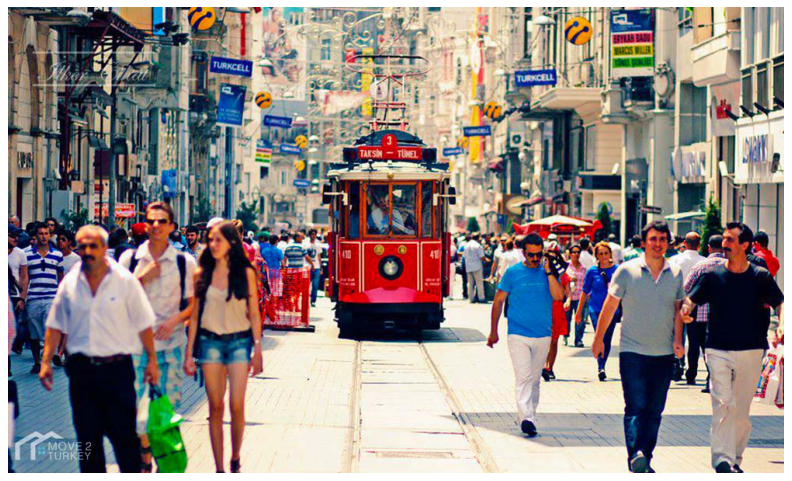

In [4]:
full_image_path = '../test_images/istanbul2.jpg'
# Read the image from file and convert to Red, Green, Blue
image_raw = Image.open(full_image_path).convert('RGB')

plt.figure(figsize=(10, 10), dpi=80)
plt.axis('off')
plt.tight_layout()
plt.imshow(image_raw)

### PyTorch deep learning models expect a tensor as input

In [5]:
# Convert raw image to tensor
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
img_transforms = transforms.Compose([
    transforms.ToTensor(),
])

### Add batch dimension (models expect it)
### (C, H, W) -> (N, C, H, W)

In [6]:
# Use .unsqueeze(0) to add dummy batch dimension
image_tensor = img_transforms(image_raw).unsqueeze(0)
print('Shape with batch dim:')
print(image_tensor.shape)

Shape with batch dim:
torch.Size([1, 3, 600, 1000])


### Make prediction with pretrained model

In [7]:
predictions = model(image_tensor)
len(predictions)

/Users/lecturer/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


1

### Model predicts:
* Boxes: bounding box covering the object (xmin, ymix, xmax, ymax)
* Labels: which class (category) it belongs to (see COCO annotation categories)
* Scores: Prediction confidence for each predicted category and bounding box
* Keypoints: Estimated keypoints (x, y, v)
* Keypoint scores: Confidence for each predicted keypoint

In [8]:
#predictions[0]

In [9]:
predictions[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

In [10]:
all_boxes = predictions[0]['boxes']
all_labels = predictions[0]['labels']
all_scores = predictions[0]['scores']
all_keypoints = predictions[0]['keypoints']
all_keypoints_scores = predictions[0]['keypoints_scores']

### Keypoints defined in format: (x, y, v)
* x, y are the coordinates of the keypoint
* v: visibility of the keypoint (0 not visible, 1 visible)

In [11]:
all_keypoints[0]

tensor([[679.5398, 324.1259,   1.0000],
        [683.2689, 316.6369,   1.0000],
        [674.3192, 317.3858,   1.0000],
        [689.2353, 315.8880,   1.0000],
        [665.3695, 315.1391,   1.0000],
        [695.9476, 343.5972,   1.0000],
        [648.9617, 341.3505,   1.0000],
        [708.6262, 372.8042,   1.0000],
        [632.5541, 378.0464,   1.0000],
        [699.6766, 342.8483,   1.0000],
        [625.8418, 418.4869,   1.0000],
        [688.4895, 424.4781,   1.0000],
        [657.9114, 423.7292,   1.0000],
        [678.7940, 479.1476,   1.0000],
        [665.3695, 475.4031,   1.0000],
        [672.8276, 527.0770,   1.0000],
        [666.1153, 530.0726,   1.0000]], grad_fn=<SelectBackward0>)

### Select high confidence (score) predictions

In [12]:
threshold = 0.8
high_confidence_indexes = torch.where(all_scores > threshold)
high_confidence_indexes

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18]),)

In [13]:
high_confidence_keypoints = all_keypoints[high_confidence_indexes]
#high_confidence_keypoints

In [14]:
high_confidence_labels = all_labels[high_confidence_indexes]
# Convert from tensor to Python list
high_confidence_labels.tolist()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## Skeleton structure
#### This defines how keypoints should be connected

In [15]:
# Copied from keypoints_json['categories'][0]['skeleton']
skeleton = [
    [16, 14],
    [14, 12],
    [17, 15],
    [15, 13],
    [12, 13],
    [6, 12],
    [7, 13],
    [6, 7],
    [6, 8],
    [7, 9],
    [8, 10],
    [9, 11],
    [2, 3],
    [1, 2],
    [1, 3],
    [2, 4],
    [3, 5],
    #[4, 6], # left_ear --> left_shoulder
    #[5, 7] # right_ear --> right_shoulder
]

### Draw each predicted keypoint and bounding box

In [16]:
def draw_keypoints_and_boxes(outputs, image, skeleton, confidence_threshold, draw_boxes=False):
    # the `outputs` is list which in-turn contains the dictionary 
    for i in range(len(outputs[0]['keypoints'])):
        # get the detected keypoints
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        # get the detected bounding boxes
        boxes = outputs[0]['boxes'][i].cpu().detach().numpy()
        
        # proceed to draw the lines and bounding boxes 
        if outputs[0]['scores'][i] > confidence_threshold: # proceed if confidence is above threshold
            keypoints = keypoints[:, :].reshape(-1, 3)
            for p in range(keypoints.shape[0]):
                # draw the keypoints
                cv2.circle(
                    image, 
                    (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                    3, 
                    (0, 0, 255), 
                    thickness=-1, 
                    lineType=cv2.FILLED
                )
                
            # draw the lines joining the keypoints
            for ie, e in enumerate(skeleton):
                # Convert index 
                e = [e[0]-1, e[1]-1]
                
                # get different colors for the edges
                rgb = matplotlib.colors.hsv_to_rgb([
                    ie/float(len(skeleton)), 1.0, 1.0
                ])
                rgb = rgb*255
                # join the keypoint pairs to draw the skeletal structure
                cv2.line(
                    image, 
                    (int(keypoints[e, 0][0]), int(keypoints[e, 1][0])),
                    (int(keypoints[e, 0][1]), int(keypoints[e, 1][1])),
                    tuple(rgb), 
                    2, 
                    lineType=cv2.LINE_AA
                )
                            
                    
            # draw the bounding boxes around the objects
            if draw_boxes:    
                cv2.rectangle(
                    image, 
                    (int(boxes[0]), int(boxes[1])), 
                    (int(boxes[2]), int(boxes[3])),
                    color=(0, 255, 0), 
                    thickness=2
                )
        else:
            continue
    return image

Total keypoints found: 19


<Figure size 432x288 with 0 Axes>

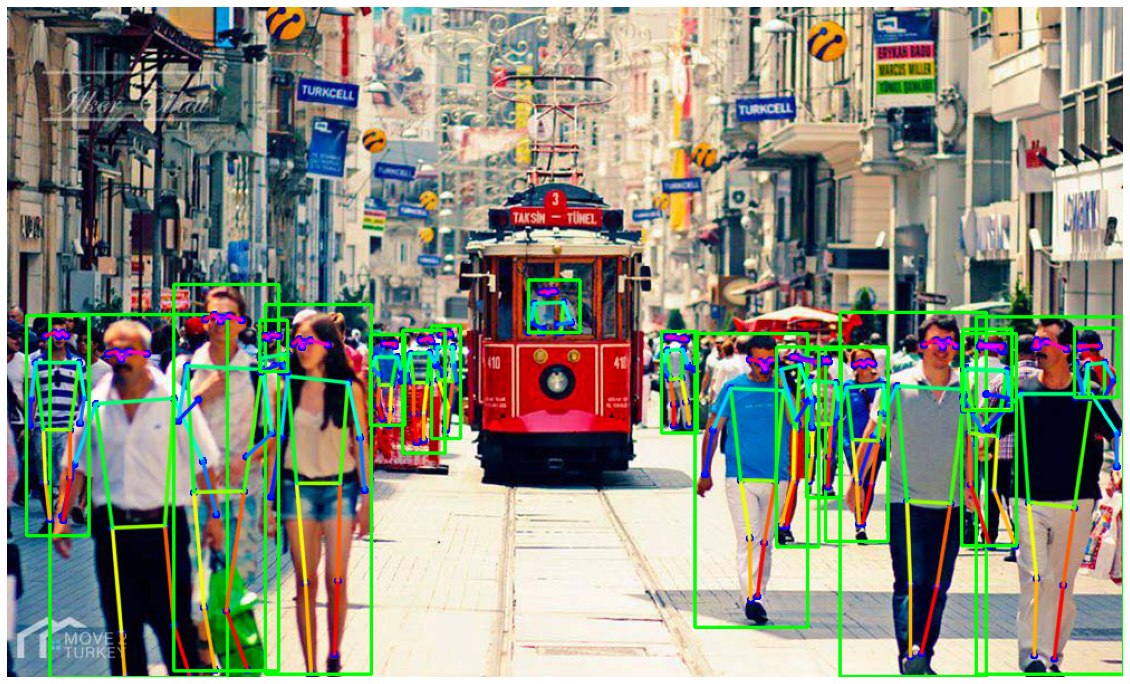

In [17]:
image_raw_copy = np.array(image_raw.copy())
print('Total keypoints found:', len(high_confidence_keypoints))

result_image = draw_keypoints_and_boxes(predictions, image_raw_copy, skeleton, threshold, draw_boxes=True)
plt.tight_layout()
plt.figure(figsize=(20, 15))
plt.axis('off')
plt.imshow(result_image)

# Keypoints from Video frames

# Additional Reading

### https://learnopencv.com/human-pose-estimation-using-keypoint-rcnn-in-pytorch/#skeleton
### https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch
##### https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py
##### https://debuggercafe.com/keypoint-and-bounding-box-detection-using-pytorch-keypoint-rcnn/
##### https://pytorch.org/vision/main/models.html
##### https://github.com/facebookresearch/detectron2
##### https://arxiv.org/pdf/1703.06870.pdf 